In [125]:
import numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro.infer.reparam import TransformReparam, LocScaleReparam
from numpyro.distributions.transforms import AffineTransform
from numpyro.infer import MCMC, NUTS, Predictive, SVI, Trace_ELBO
from numpyro.infer.autoguide import AutoLaplaceApproximation
import numpyro.optim as optim
from numpyro import handlers
from numpyro.handlers import mask
from jax.numpy import DeviceArray
import jax.numpy as jnp
from jax import random
from jax import nn as jnn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, roc_auc_score

In [66]:
seed = 1
rng_key = random.PRNGKey(seed)

In [43]:
raw_data = ['W', 'L', 'W', 'W', 'W', 'L', 'W', 'L', 'W']
map = {'W':1.0, 'L':0.0}
data = jnp.array([ map[i] for i in raw_data ])

In [129]:
def model(data=None):#, n=10):
    if data is None:
        num_obs = 10
    else:
        num_obs = len(data)
    p = numpyro.sample("p", dist.Uniform(0.0,1.0)) #prior on proportion of earth's surface that is water
    with numpyro.plate('obs_plate', num_obs):
        obs = numpyro.sample("obs", dist.BernoulliProbs(p), obs=data)

    return obs

In [132]:
with handlers.seed(rng_seed=0):
    result = model()

In [133]:
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_warmup=2000, num_samples=10000)
rng_key = random.PRNGKey(42)
mcmc.run(rng_key, data)
mcmc.print_summary()

sample: 100%|██████████| 12000/12000 [00:04<00:00, 2422.31it/s, 3 steps of size 1.13e+00. acc. prob=0.89]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         p      0.64      0.14      0.64      0.41      0.87   3753.33      1.00

Number of divergences: 0


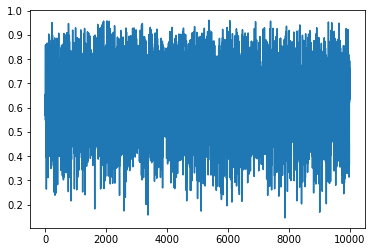

In [59]:
samples = mcmc.get_samples()
plt.plot(samples['p'])

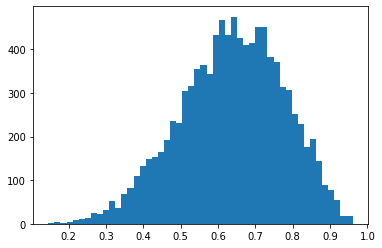

In [60]:
_ = plt.hist(samples['p'], bins=50)

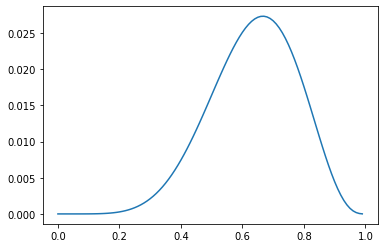

In [84]:
x = jnp.arange(0,1,0.01)
w = data.sum()
n = len(data)

log_l = dist.Binomial(n, x).log_prob(w)
l = jnp.exp(log_l)
tot_l = sum(l)

pos = l / tot_l

plt.plot(x,pos)

mean:  0.6363636


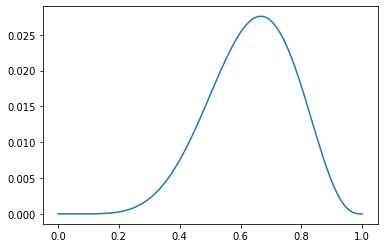

In [138]:
num_p = 100
x = jnp.linspace(0,1,num_p)
n = len(data)

log_l = dist.BernoulliProbs(x).expand([n, num_p]).log_prob(jnp.tile(data, (num_p,1)).T).sum(axis=0)
l = jnp.exp(log_l)
tot_l = sum(l)
pos = l / tot_l

plt.plot(x,pos)
print('mean: ',(x*pos).sum())


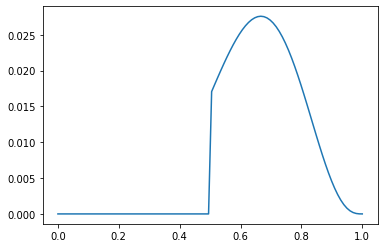

In [120]:
num_p = 100
x = jnp.linspace(0,1,num_p)
n = len(data)
prior = jnp.where(x < 0.5, 0, 1)

log_l = dist.BernoulliProbs(x).expand([n, num_p]).log_prob(jnp.tile(data, (num_p,1)).T).sum(axis=0)
l = jnp.exp(log_l)
tot_l = sum(l)
pos = ( l * prior ) / tot_l

plt.plot(x,pos)

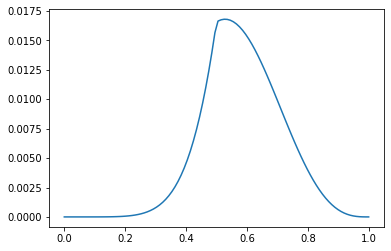

In [121]:
num_p = 100
x = jnp.linspace(0,1,num_p)
n = len(data)
prior = jnp.exp(-5*jnp.abs(x-0.5))

log_l = dist.BernoulliProbs(x).expand([n, num_p]).log_prob(jnp.tile(data, (num_p,1)).T).sum(axis=0)
l = jnp.exp(log_l)
tot_l = sum(l)
pos = ( l * prior ) / tot_l

plt.plot(x,pos)

In [135]:
from numpyro.infer.autoguide import AutoLaplaceApproximation

guide = AutoLaplaceApproximation(model)
svi = SVI(model, guide, optim.Adam(1), Trace_ELBO())
svi_result = svi.run(random.PRNGKey(0), 10000, data)
params = svi_result.params
# display summary of quadratic approximation
samples = guide.sample_posterior(random.PRNGKey(1), params, (10000,))
numpyro.diagnostics.print_summary(samples, group_by_chain=False)


100%|██████████| 10000/10000 [00:01<00:00, 8613.65it/s, init loss: 7.3586, avg. loss [9501-10000]: 7.2114]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         p      0.63      0.14      0.63      0.41      0.85   8815.09      1.00



(array([  11.,    8.,   13.,    8.,   36.,   64.,   67.,  113.,  128.,
         189.,  301.,  369.,  524.,  635.,  677.,  992., 1208., 1395.,
        1741., 1936., 2245., 2534., 2872., 3167., 3374., 3663., 4010.,
        4215., 4304., 4671., 4880., 4819., 4824., 4624., 4624., 4433.,
        4157., 4032., 3663., 3173., 2714., 2357., 1982., 1504., 1124.,
         727.,  507.,  261.,   91.,   34.]),
 array([0.10047897, 0.11810366, 0.13572836, 0.15335306, 0.17097775,
        0.18860245, 0.20622715, 0.22385184, 0.24147654, 0.25910123,
        0.27672593, 0.29435063, 0.31197532, 0.32960002, 0.34722472,
        0.36484941, 0.38247411, 0.4000988 , 0.4177235 , 0.4353482 ,
        0.45297289, 0.47059759, 0.48822229, 0.50584698, 0.52347168,
        0.54109637, 0.55872107, 0.57634577, 0.59397046, 0.61159516,
        0.62921986, 0.64684455, 0.66446925, 0.68209394, 0.69971864,
        0.71734334, 0.73496803, 0.75259273, 0.77021743, 0.78784212,
        0.80546682, 0.82309151, 0.84071621, 0.85834091, 

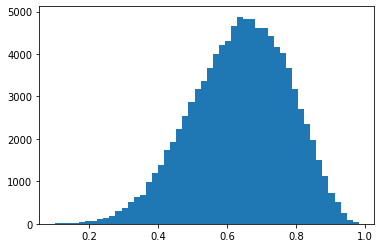

In [146]:
# Metropolis algo for MCMC - adaptation from R code 2.8 (p45)
from scipy.stats import norm, binom, uniform

n_samples = 100000
p = np.full((n_samples), np.nan)
p[0] = 0.5
W = 6
L = 3
for i in range(1,n_samples):
    p_new = norm(loc=p[i-1], scale=0.1).rvs(1)
    if p_new < 0:
        p_new = abs(p_new)
    elif p_new > 1:
        p_new = 2 - p_new
    q0 = binom(W+L, p[i-1]).pmf(W)
    q1 = binom(W+L, p_new).pmf(W)
    p[i] = p_new if uniform(0,1).rvs(1) < q1/q0 else p[i-1].

plt.hist(p, bins = 50)